# INFN-MILANO-ATLASC_LOCALGROUPDISK

In [1]:
import numpy as np
import pandas as pd
import logging
import datetime
import urllib2

from IPython.display import display, HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'coolwarm'  # quite good colormap, should avoid rainbow problems

%matplotlib inline
%autosave 30

Autosaving every 30 seconds



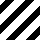
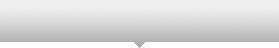
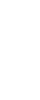
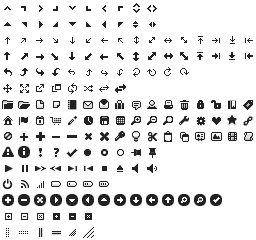
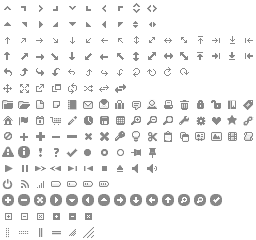
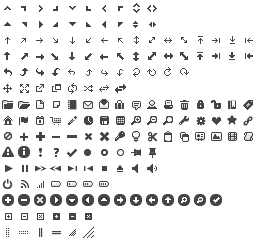
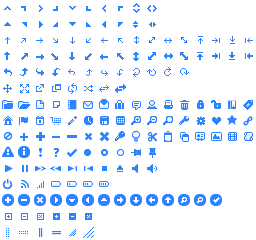
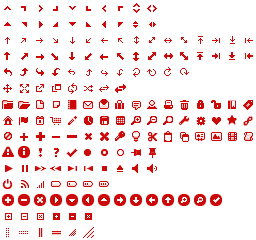
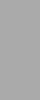
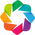
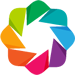
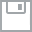
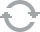
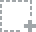
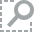
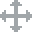
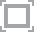
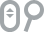

In [2]:
from bokeh.io import output_notebook
output_notebook()

In [3]:
# TODO: solve this
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
Gb = 1024. ** 3
Tb = 1024. ** 4

## Import data

In [48]:
def to_pandas(filename, dateformat='ms', noderived=False):
    def conv(s):
        if "panda" in s:
            s = s.replace("panda,", "").replace(",panda", "")
        if "root" in s:
            s = s.replace("root,", "").replace(",root", "")
        if "," in s:
            items = s.split(",")
            if len(set(items)) == 1:
                s = items[0]
        return s  
    try:
        if noderived:
            data =  pd.read_csv(filename, sep='\t', header=None,                                
                                converters={3: conv},
                                usecols=[0,1,2,3,4]
                                )
            data.columns = ["RSE", "scope", "name", "owner", "size"]
        else:
            if dateformat == 'ms':
                names = ("RSE", "scope", "name", "owner", "size", "creation_date", "last_accessed_date")
                data =  pd.read_csv(filename, sep='\t', header=None,
                                    parse_dates=["creation_date", "last_accessed_date"],
                                    date_parser=lambda _:pd.to_datetime(float(_), unit='ms'),
                                    converters={"owner": conv},
                                    names=names)

            elif dateformat == 'string':
                names = ("RSE", "scope", "name", "owner", "size", "creation_date", "last_accessed_date")

                data =  pd.read_csv(filename, sep='\t', header=None,
                                    parse_dates=['creation_date', 'last_accessed_date'],
                                    converters={"owner": conv},
                                    names=names)
    except Exception as ex:
        if type(ex) != urllib2.HTTPError:
            print "cannot parse file from %s" % filename
        raise

    if not noderived:
        now = datetime.datetime.now()
        data.loc[data['creation_date'].notnull(), 'age_days'] = (now - data['creation_date']).dt.days
        data.loc[data['last_accessed_date'].notnull(), 'last_accessed_days'] = (now - data['last_accessed_date']).dt.days
        data['life_days'] = data['age_days'] - data['last_accessed_days']
    
    return data


In [6]:
def get_data(rse, date, **kwargs):
    datestr = date.strftime('%d-%m-%Y')
    url = "https://rucio-hadoop.cern.ch/consistency_datasets?rse=%s&date=%s" % (rse, datestr)    
    return to_pandas(url, dateformat='ms' if date >= datetime.datetime(2015, 7, 31) else 'string', **kwargs)

In [7]:
milano_rse = "INFN-MILANO-ATLASC_LOCALGROUPDISK"
yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
date = yesterday

data = get_data(milano_rse, date)

### Print the first datasets

In [8]:
data.head()

,RSE,scope,name,owner,size,creation_date,last_accessed_date,age_days,last_accessed_days,life_days
0,INFN-MILANO-ATLASC_LOCALGROUPDISK,data12_8TeV,data12_8TeV.00202660.physics_Egamma.merge.DAOD...,smazza,258483466,2015-03-31 11:03:26,NaT,165,NaN,NaN
1,INFN-MILANO-ATLASC_LOCALGROUPDISK,data12_8TeV,data12_8TeV.00202668.physics_Egamma.merge.DAOD...,smazza,3225407726,2015-03-31 11:03:08,NaT,165,NaN,NaN
2,INFN-MILANO-ATLASC_LOCALGROUPDISK,data12_8TeV,data12_8TeV.00202712.physics_Egamma.merge.DAOD...,smazza,4617548374,2015-03-31 11:03:50,NaT,165,NaN,NaN
3,INFN-MILANO-ATLASC_LOCALGROUPDISK,data12_8TeV,data12_8TeV.00202740.physics_Egamma.merge.DAOD...,smazza,1216433739,2015-03-31 11:03:09,NaT,165,NaN,NaN
4,INFN-MILANO-ATLASC_LOCALGROUPDISK,data12_8TeV,data12_8TeV.00202798.physics_Egamma.merge.DAOD...,smazza,4260994621,2015-03-31 11:03:24,NaT,165,NaN,NaN


## Total size

In [9]:
total = data['size'].sum() / Tb
print "total usage = %.2f Tb" % total

total usage = 50.80 Tb


## Users sorted by usage

In [11]:
def group_by_owner(data):
    default_actions = {'owner':'count', 'life_days': 'mean', 'age_days': 'mean', 'last_accessed_days': 'mean', 'size': lambda x: np.sum(x) / Tb}
    actions = {k: default_actions[k] for k in data.columns if k in default_actions}
    result = data.groupby("owner").agg(actions)
    result.columns = ['ndatasets'] + list(result.columns)[1:]
    return result

group_owner = group_by_owner(data)
group_owner = group_owner.sort(['size'])

group_owner

,ndatasets,life_days,last_accessed_days,age_days,size
owner,,,,,
tlari,584,10.272727,141.522727,99.739726,0.026796
resconi,21,NaN,NaN,17.000000,0.249007
mfanti,13,150.000000,5.000000,155.000000,3.353900
mratti,142,17.620690,53.327586,65.415493,5.322575
lcarmina,332,23.970588,50.317647,59.198795,5.353726
"mivipe,smazza",23,70.681818,28.318182,99.000000,9.747902
smazza,191,63.641509,74.716981,117.450262,9.933463
mivipe,145,44.172043,28.569892,81.165517,16.817606


In [12]:
from bokeh.charts import Donut, Bar, output_file, show
from bokeh import mpl, models

p = Bar(group_owner['ndatasets'], group_owner.index.tolist(), ylabel='datasets', tools='hover')
hover = p.select(dict(type=models.HoverTool))
hover.tooltips = [('user', '$x'),
                  ('#datasets', '$value')]
p.toolbar_location = None
p.plot_width = 800
p.plot_height = 400

show(p)

ERROR:/usr/envs/newenv/lib/python2.7/site-packages/bokeh/validation/check.pyc:W-1003 (MALFORMED_CATEGORY_LABEL): Category labels are malformed: [field:cat0] [first_value: tlari:0.5] [renderer: GlyphRenderer, ViewModel:GlyphRenderer, ref _id: 40d6917d-669d-472c-9088-c5a994dfce3a]


## Size of the datasets

There are many small datasets

count    1429.000000
mean       36.406085
std       123.505268
min         0.000119
25%         0.011086
50%         0.131847
75%        10.419594
max      1074.139613
Name: size, dtype: float64

median dataset = 0.15 GB
fraction dataset < 1 GB = 58.0%
fraction dataset < 100 MB = 46.0%
5 smallest samples


,RSE,owner,name,size
89,INFN-MILANO-ATLASC_LOCALGROUPDISK,lcarmina,data15_13TeV.00267148.physics_Main.merge.DAOD_...,127987
88,INFN-MILANO-ATLASC_LOCALGROUPDISK,lcarmina,data15_13TeV.00267148.physics_Main.merge.DAOD_...,127997
914,INFN-MILANO-ATLASC_LOCALGROUPDISK,tlari,user.tlari.210028.MadGraphPythia_AUET2B_CTEQ6L...,161450
920,INFN-MILANO-ATLASC_LOCALGROUPDISK,tlari,user.tlari.211214.MadGraphPythia_AUET2B_CTEQ6L...,162461
926,INFN-MILANO-ATLASC_LOCALGROUPDISK,tlari,user.tlari.211458.MadGraphPythia_AUET2B_CTEQ6L...,163254


5 largest samples


,RSE,owner,name,size
634,INFN-MILANO-ATLASC_LOCALGROUPDISK,"mivipe,smazza",mc15_13TeV.361045.Sherpa_CT10_SinglePhotonPt14...,9.059117e+11
635,INFN-MILANO-ATLASC_LOCALGROUPDISK,mivipe,mc15_13TeV.361045.Sherpa_CT10_SinglePhotonPt14...,9.059974e+11
624,INFN-MILANO-ATLASC_LOCALGROUPDISK,mivipe,mc15_13TeV.361043.Sherpa_CT10_SinglePhotonPt70...,9.126266e+11
655,INFN-MILANO-ATLASC_LOCALGROUPDISK,mivipe,mc15_13TeV.361046.Sherpa_CT10_SinglePhotonPt14...,1.015797e+12
829,INFN-MILANO-ATLASC_LOCALGROUPDISK,mratti,user.khoo.361107.PowhegPythia8EvtGen_AZNLOCTEQ...,1.153349e+12


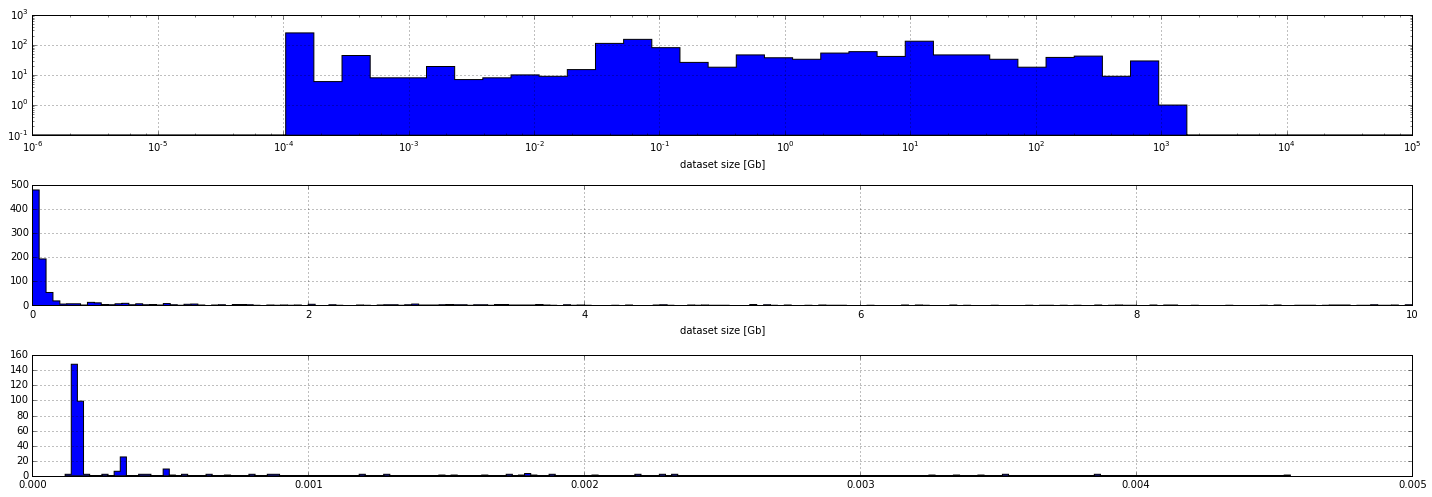

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(20, 7))

median = np.median(data['size']) / Gb

data_size_not_null_Gb = data[data['size'].notnull()]['size'] / Gb

data_size_not_null_Gb.hist(bins=np.logspace(-6, 5, 50), ax=ax[0], log=True, histtype='stepfilled')
data_size_not_null_Gb.hist(bins=200, range=(0, 10), ax=ax[1], histtype='stepfilled')
data_size_not_null_Gb[data_size_not_null_Gb < .005].hist(bins=200, ax=ax[2], histtype='stepfilled')
ax[0].set_xscale('log')
ax[0].set_xlabel('dataset size [Gb]')
ax[1].set_xlabel('dataset size [Gb]')


fig.tight_layout()

display((data['size'] / Gb).describe())

print "median dataset = %.2f GB" % (median)
print "fraction dataset < 1 GB = %.1f%%" % (len(data[data['size'] / (1024.**3) < 1]) / float(len(data)) * 100.)
print "fraction dataset < 100 MB = %.1f%%" % (len(data[data['size'] / (1024.**2) < 100]) / float(len(data)) * 100.)

print "5 smallest samples"
display(data[data['size'].notnull()].sort('size')[:5][['RSE', 'owner', 'name', 'size']])
print "5 largest samples"
display(data[data['size'].notnull()].sort('size')[-5:][['RSE', 'owner', 'name', 'size']])


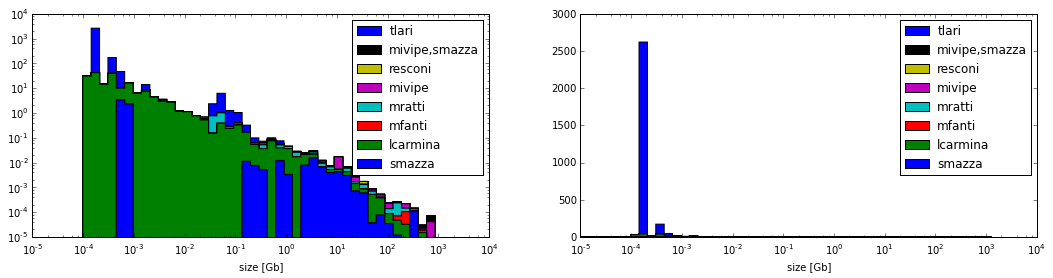

In [14]:
f, axs = plt.subplots(1, 2, figsize=(18, 4))

g = data.groupby('owner')['size']
owners = data['owner'].unique()

axs[0].hist([g.get_group(user).as_matrix() / Gb for user in owners], bins=(np.logspace(-5, 3.1, 50)), stacked=True, fill=True, histtype='stepfilled', label=tuple(owners), normed=True)
axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel('size [Gb]')


axs[1].hist([g.get_group(user).as_matrix() / Gb for user in owners], bins=(np.logspace(-5, 3.1, 50)), stacked=True, fill=True, histtype='stepfilled', label=tuple(owners), normed=True)
axs[1].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel('size [Gb]')

plt.show()

### Dataset age (when they are created)

average age: 86 days


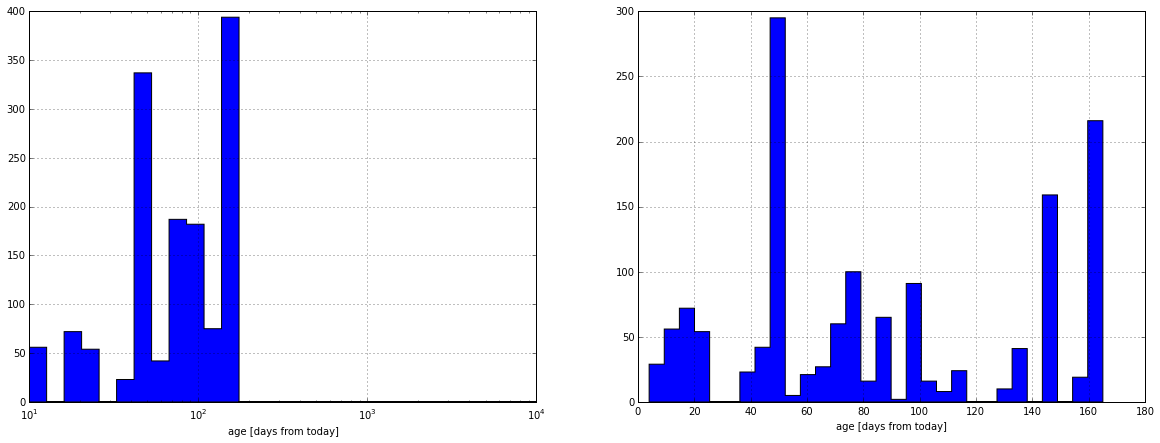

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
data['age_days'].hist(bins=np.logspace(1, 4, 30), ax=ax[0], histtype='stepfilled')
data['age_days'].hist(bins=30, ax=ax[1], histtype='stepfilled')

ax[0].set_xscale('log')
for a in ax: a.set_xlabel('age [days from today]')
print "average age: %d days" % data.age_days.mean()

### Dataset last access

average last access: 56 days


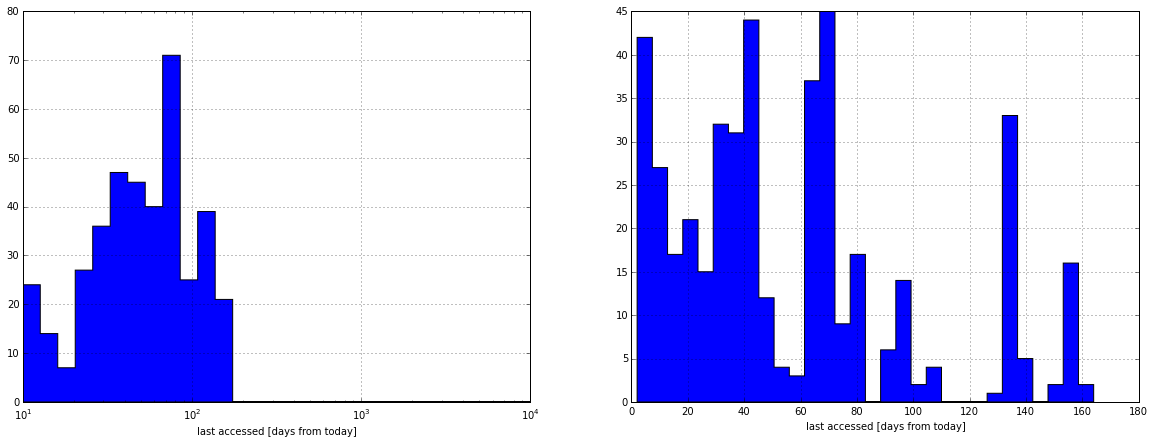

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
data['last_accessed_days'].hist(bins=np.logspace(1, 4, 30), ax=ax[0], histtype='stepfilled')
data['last_accessed_days'].hist(bins=30, ax=ax[1], histtype='stepfilled')
ax[0].set_xscale('log')
for a in ax: a.set_xlabel('last accessed [days from today]')
print "average last access: %d days" % data.last_accessed_days.mean()

### Life (time between creation and last access)

average life: 33 days


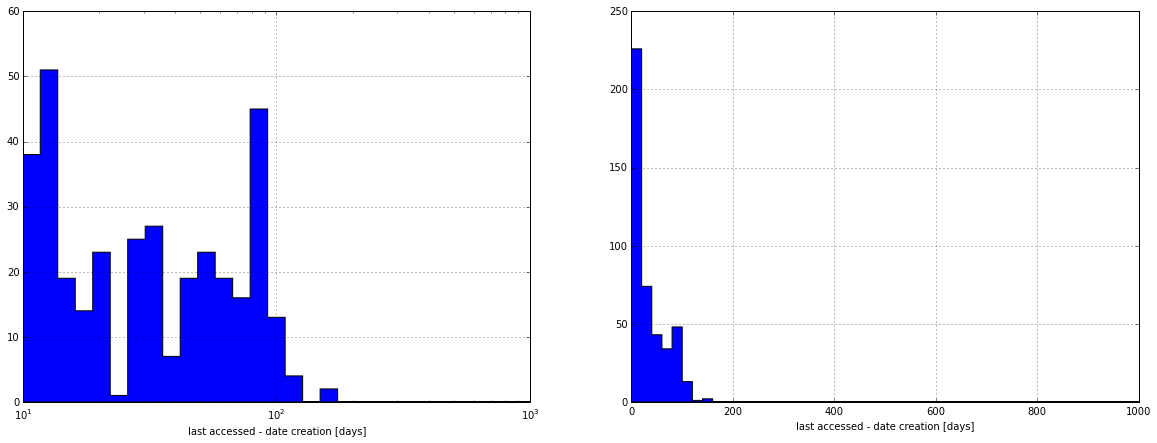

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
data['life_days'].hist(bins=np.logspace(1, 3, 30), ax=ax[0], histtype='stepfilled')
data['life_days'].hist(bins=50, ax=ax[1], range=(0, 1000), histtype='stepfilled')
ax[0].set_xscale('log')
for a in ax: a.set_xlabel('last accessed - date creation [days]')

print "average life: %d days" % data.life_days.mean()

### Correlations

No correlation between size and age or last access

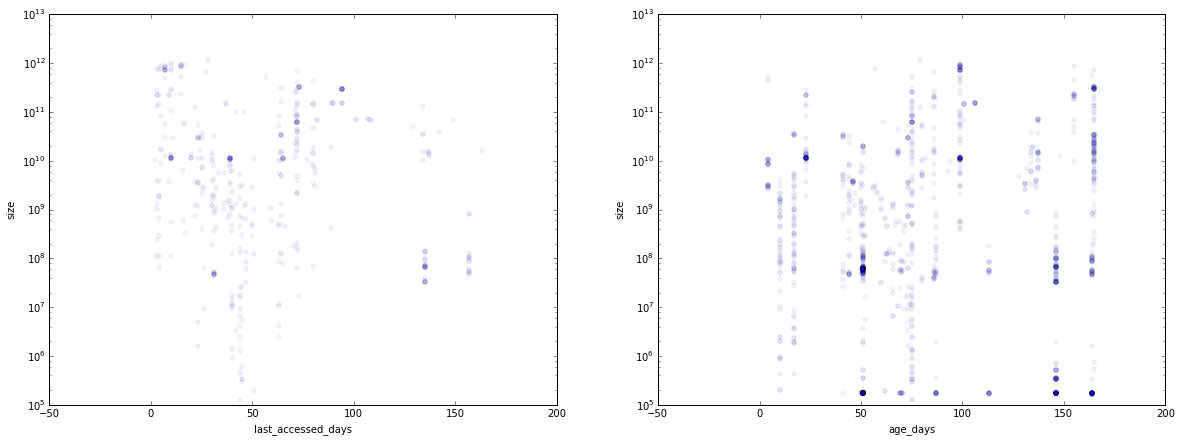

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
data.plot(kind='scatter', y='size', x='last_accessed_days', ax=ax[0], alpha=0.05)
ax[0].set_yscale('log')

data.plot(kind='scatter', y='size', x='age_days', ax=ax[1], alpha=0.05)
ax[1].set_yscale('log')

In [19]:
corr = data.corr()
corr

,size,age_days,last_accessed_days,life_days
size,1.000000,0.123482,-0.237369,0.540570
age_days,0.123482,1.000000,0.725367,0.376764
last_accessed_days,-0.237369,0.725367,1.000000,-0.364344
life_days,0.540570,0.376764,-0.364344,1.000000


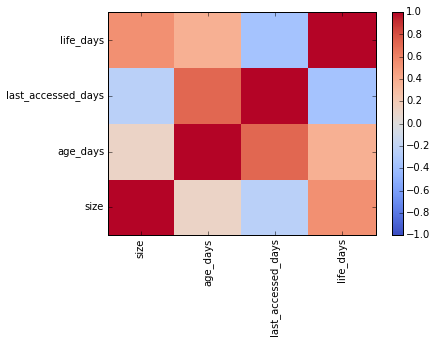

In [20]:
fig, ax = plt.subplots()
p = ax.pcolormesh(np.nan_to_num(corr.values), vmin=-1, vmax=1)
ax.set_yticklabels(corr.index)
ax.set_xticklabels(corr.index, rotation=90)
ax.set_yticks(np.arange(len(corr.index)) + 0.5)
ax.set_xticks(np.arange(len(corr.index)) + 0.5)
plt.colorbar(p)

plt.show()

## User analysis

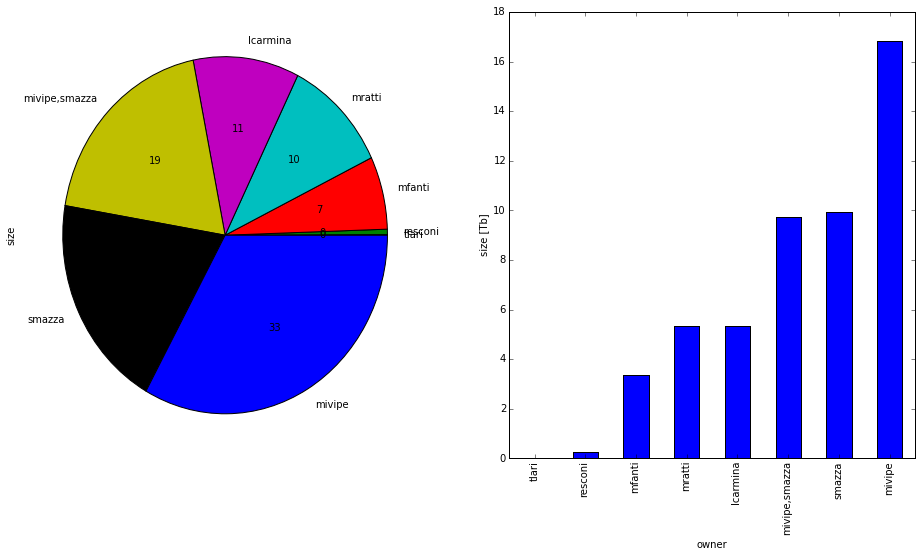

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
group_owner['size'].plot(kind='pie', autopct='%.0f', ax=ax[0])
group_owner['size'].plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('size [Tb]')
plt.show()

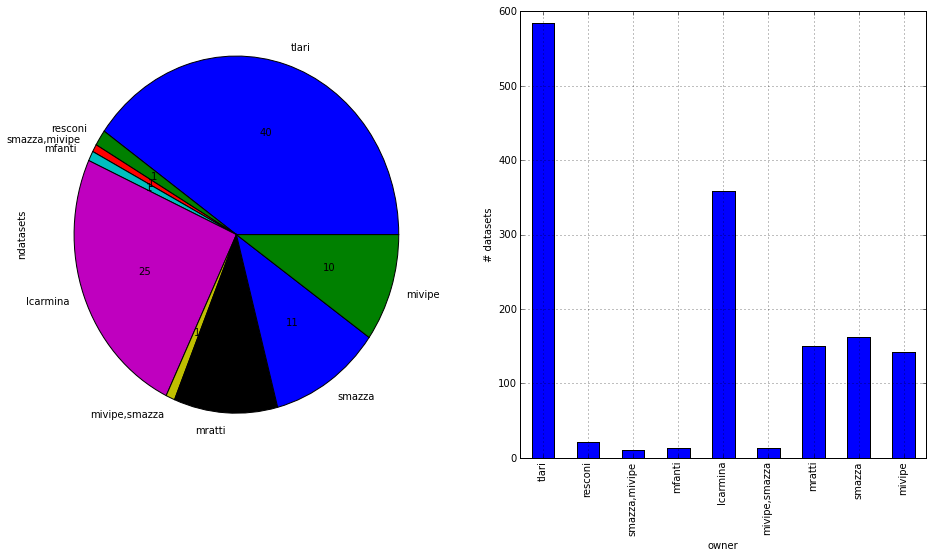

In [299]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
group_owner['ndatasets'].plot(kind='pie', autopct='%.0f', ax=ax[0])
group_owner['ndatasets'].plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('# datasets')
plt.show()

### Size per dataset

some users have huge datasets

mean dataset size = 35.69 Gb


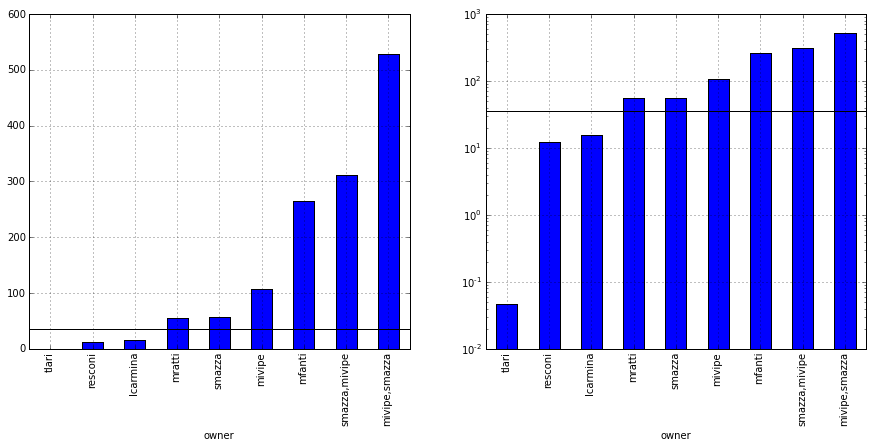

In [300]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ave_size = group_owner['size'] / group_owner['ndatasets'] * 1024  # Gb
ave_size.sort()
ave_size.plot(kind='bar', ax=ax[0])
ave_size.plot(kind='bar', ax=ax[1])
ax[1].set_yscale('log')
ave = data['size'].sum() / float(len(data)) / (1024 ** 3)
ax[0].hlines(ave, *ax[0].get_xlim())
ax[1].hlines(ave, *ax[0].get_xlim())
print "mean dataset size = %.2f Gb" % ave

### Average age

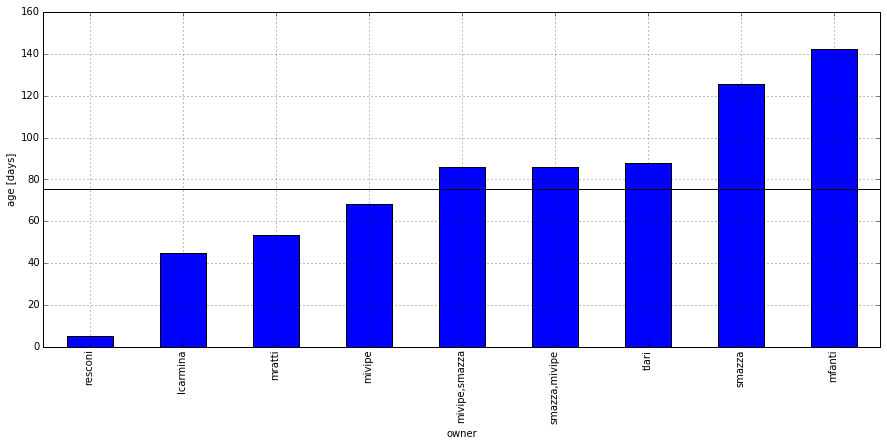

In [301]:
fig, ax = plt.subplots(figsize=(15, 6))
grouped_age_days = data.groupby(["owner"])["age_days"].mean()
grouped_age_days.sort()
grouped_age_days.plot(kind='bar', ax=ax)
ax.hlines(np.mean(data['age_days']), *ax.get_xlim())
ax.set_ylabel('age [days]')

### Average last access

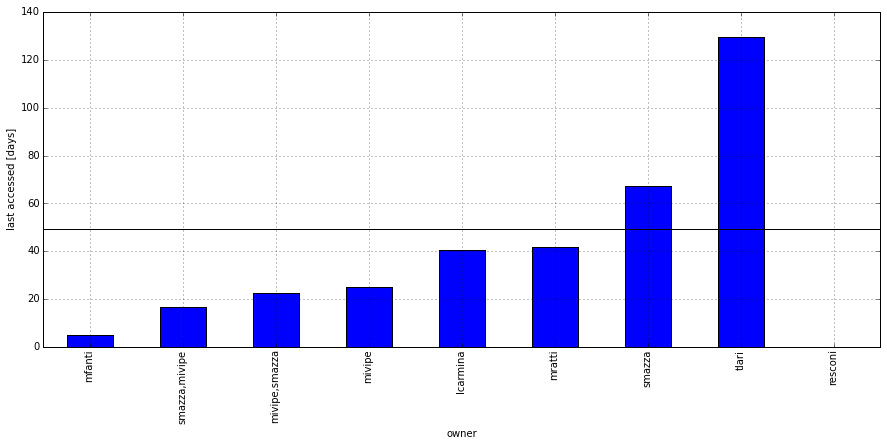

In [302]:
fig, ax = plt.subplots(figsize=(15, 6))
grouped_lastacc_days = data.groupby(["owner"])["last_accessed_days"].mean()
grouped_lastacc_days.sort()
grouped_lastacc_days.plot(kind='bar', ax=ax)
ax.hlines(np.mean(data['last_accessed_days']), *ax.get_xlim())
ax.set_ylabel('last accessed [days]')

### Average life

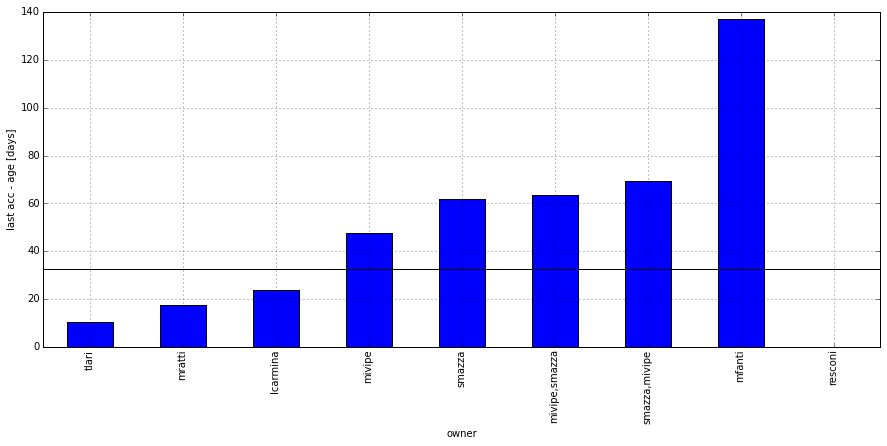

In [303]:
fig, ax = plt.subplots(figsize=(15, 6))
grouped_life_days = data.groupby(["owner"])["life_days"].mean()
grouped_life_days.sort()
grouped_life_days.plot(kind='bar', ax=ax)
ax.hlines(np.mean(data['life_days']), *ax.get_xlim())
ax.set_ylabel('last acc - age [days]')

## History

In [49]:
import multiprocessing.dummy
import urllib2

datelist = pd.date_range(end=yesterday, periods=500).tolist()

p = multiprocessing.dummy.Pool(50)

def fetch_safe(date):
    try:
        d = get_data(milano_rse, date, noderived=True)
        do = group_by_owner(d)
        do = do.reset_index()
        do['timestamp'] = date
        return do
    except urllib2.HTTPError:
        pass
    except:
        print "problem parsing data for %s" % date
        raise

datas_owner = p.map(fetch_safe, datelist)
data = pd.concat(datas_owner)

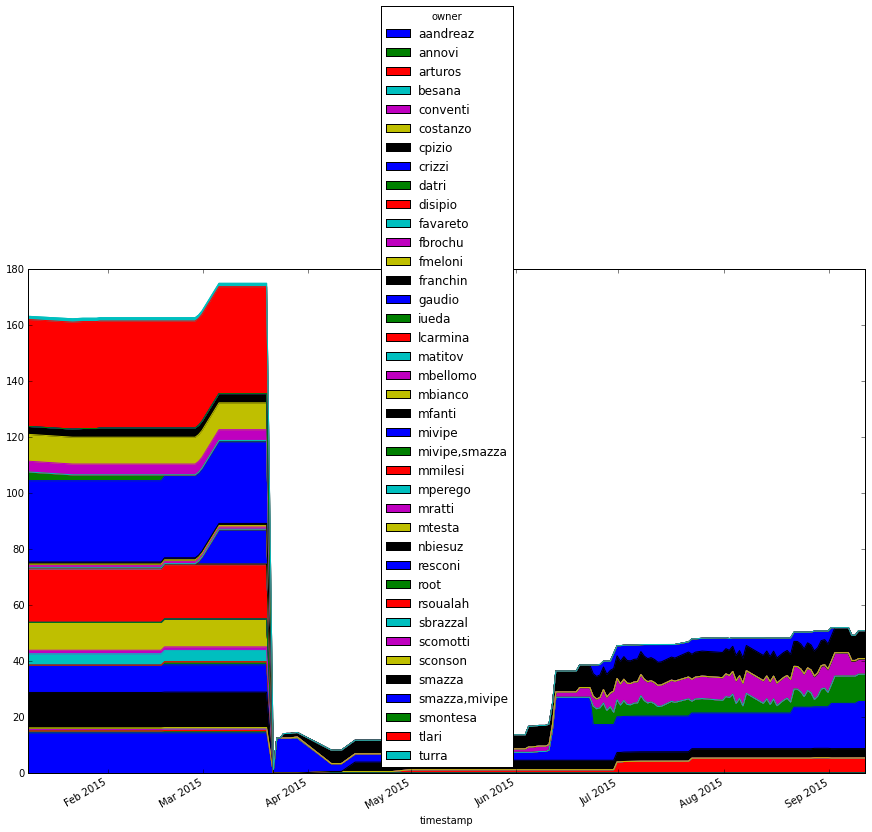

In [50]:
data.groupby(['timestamp', 'owner'])['size'].sum().unstack().plot(kind='area', figsize=(15, 10))